In [1]:
import h5py, os, pystan
import numpy as np
from os.path import dirname
from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
import os, pystan
import _pickle as pickle
from pandas import DataFrame

def load_model(filepath):
    """Load or precomplile a StanModel object.
    Parameters
    ----------
    filepath : str
        Path to the Stan model.
    Returns
    -------
    StanModel : pystan.StanModel
        Model described in Stan’s modeling language compiled from C++ code.
    Notes
    -----
    If an extensionless filepath is supplied, looks for *.stan or *.txt files for StanCode 
    and *.pkl and *.pickle for StanModels. Otherwise requires a file with one of those four extensions.
    """

    for ext in ['.pkl','.pickle','.stan','.txt']:

        if filepath.endswith(ext):
            break
        elif os.path.isfile(filepath + ext):
            filepath += ext
            break

    if filepath.lower().endswith(('.pkl','.pickle')):

        ## Load pickle object.
        StanModel = pickle.load(open(filepath, 'rb'))

    elif filepath.lower().endswith(('.stan','.txt')):

        ## Precompile StanModel.
        StanModel = pystan.StanModel(file=filepath)

        ## Dump to pickle object.
        f = '.'.join(filepath.split('.')[:-1]) + '.pkl'
        with open(f, 'wb') as f: pickle.dump(StanModel, f)

    else:

        raise IOError('%s not correct filetype.' %filepath)

    return StanModel

In [3]:
PATH_NAME = '/Users/kierstenmarr/Desktop/TDLR'

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'TLDR.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [5]:
from numba import njit

@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

# TDLR written similar to Sam's MB python code

In [6]:
class TDLR(object):
    
    def __init__(self, beta_1, beta_2, alpha_com, alpha_rare):
        
        ## Define parameters.
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.alpha_com = alpha_com
        self.alpha_rare = alpha_rare
        
        ## Initialize Q-values.
        self.Q = None
        self.MB = None
        
    def train(self, drifts, reset=False):

        ## Initialize Q-values.
        self.Q = np.ones((2,2)) * 0.5
        self.MB = np.ones(2) * 0.5
            
        ## Preallocate space.
        n_trials = drifts.shape[0]
        Y1, Y2, S2, t, r = np.zeros((5,n_trials), dtype=int)
            
        for i in range(n_trials):
            
            ## Stage 1: Compute choice likelihood.
            theta = inv_logit( self.beta_1 * (self.MB[1] - self.MB[0]) )
            
            ## Stage 1: Simulate choice.
            Y1[i] = np.random.binomial(1,theta)
            
            ## Simulate transition.
            t[i] = np.random.binomial(1, 0.7)
            S2[i] = np.where(t[i], Y1[i], 1-Y1[i])
                        
            ## Stage 2: Compute choice likelihood.
            theta = inv_logit( self.beta_2 * (self.Q[S2[i],1] - self.Q[S2[i],0]) )
            
            ## Stage 2: Simulate choice.
            Y2[i] = np.random.binomial(1,theta)
            
            ## Stage 2: Observe outcome.
            #r[i] = R[i,S2[i]-1,Y2[i]]
            r[i] = np.random.binomial(1, drifts[i, S2[i], Y2[i]])
            
            # Check for transition type and assign LR
            if t[i]:
                alpha = self.alpha_com
            else:
                alpha = self.alpha_rare
            
            ## Stage 2: Update Q-values.
            self.Q[S2[i],Y2[i]] += alpha * ( r[i] - self.Q[S2[i],Y2[i]] )
            
            ## Update Stage 1 Q values
            self.MB[0] = 0.7*np.max(self.Q[0]) + 0.3*np.max(self.Q[1])
            self.MB[1] = 0.3*np.max(self.Q[0]) + 0.7*np.max(self.Q[1])
            
        return Y1, t, S2, Y2, r

In [7]:
from tqdm import tqdm

In [8]:
import seaborn as sns
sns.set('notebook', style='white', font='sans-serif', font_scale=1.33)

100%|██████████| 201/201 [00:03<00:00, 65.59it/s]


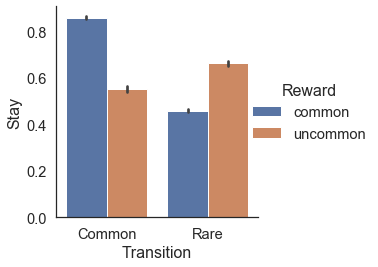

In [9]:
np.random.seed(47404)

## Define reward parameters.
drifts = read_csv('drifts.txt', header=None).values.reshape(-1,2,2)
T = drifts.shape[0]

data = []
for _ in tqdm(range(T)):
    
    ## Simulate outcomes.
    #R = np.random.binomial(1, [[0.7,0.3],[0.3,0.7]], (200,2,2))
    
    ## Initialize agent.
    agent = TDLR(beta_1 = 7, beta_2 = 7, alpha_com = 0.8, alpha_rare=0.2)

    ## Train agent.
    Y1, t, S2, Y2, r = agent.train(drifts)
    
    ## Define variables.
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = Y1[:-1] == Y1[1:]

    ## Blah.
    df = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

In [15]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=t, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_db58d91b7690f4415cd073d9864d383a NOW.


In [16]:
StanModel.optimizing(data=dd)

OrderedDict([('beta1_pr', array(-1.16813655)),
             ('beta2_pr', array(-0.90647143)),
             ('etaC_pr', array(0.37147735)),
             ('etaR_pr', array(-0.94675005)),
             ('beta1', array(2.42918036)),
             ('beta2', array(3.64631977)),
             ('etaC', array(0.6449901)),
             ('etaR', array(0.17187374)),
             ('Y1_pd', array(0.51441628)),
             ('Y2_pd', array(0.60895908))])

In [17]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=47404)

In [14]:
print(StanFit)

Inference for Stan model: anon_model_572e27fec879f5dd38deb23d5d8ed050.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1_pr  -1.31  5.0e-3   0.32  -2.07  -1.48  -1.27   -1.1  -0.81   4022    1.0
beta2_pr  -0.92  2.2e-3   0.15  -1.21  -1.02  -0.92  -0.82  -0.63   4396    1.0
etaC_pr    0.48  6.6e-3   0.38  -0.12   0.23   0.44   0.69   1.35   3270    1.0
etaR_pr   -1.23    0.01   0.59  -2.76  -1.47  -1.08  -0.84  -0.43   2781    1.0
beta1       2.1    0.01   0.98   0.39   1.39   2.04   2.73   4.17   5769    1.0
beta2      3.63    0.01   0.77   2.28   3.08   3.58   4.11   5.25   4447    1.0
etaC       0.67  1.7e-3   0.12   0.45   0.59   0.67   0.75   0.91   4500    1.0
etaR       0.14  1.4e-3   0.09 2.8e-3   0.07   0.14    0.2   0.33   4086    1.0
lp__     -255.3    0.04    1.7 -259.5 -256.2 -255.0 -254.0 -253.0   2319    1.0

Samples we